## Load Model Data

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio
import glob
from src.modeling.ElasticWaveMod import Elastic2DDevito
# from visual import explode_volume

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
#Load data
fvp = segyio.open(r'/home/khatamm/SEAM_Arid/Arid_vpData.sgy', ignore_geometry=True)
fvs = segyio.open(r'/home/khatamm/SEAM_Arid/Arid_vsData.sgy', ignore_geometry=True)
frho = segyio.open(r'/home/khatamm/SEAM_Arid/Arid_rhoData.sgy', ignore_geometry=True)

In [10]:
vp = segyio.collect(fvp.trace[:])
vs = segyio.collect(fvs.trace[:])
rho = segyio.collect(frho.trace[:])

In [11]:
#Conditioning Data 
vp = vp.reshape(1600, 1600, 600).transpose(2,0,1)
vs = vs.reshape(1600, 1600, 600).transpose(2,0,1)
rho = rho.reshape(1600, 1600, 600).transpose(2,0,1)
b = 1/rho

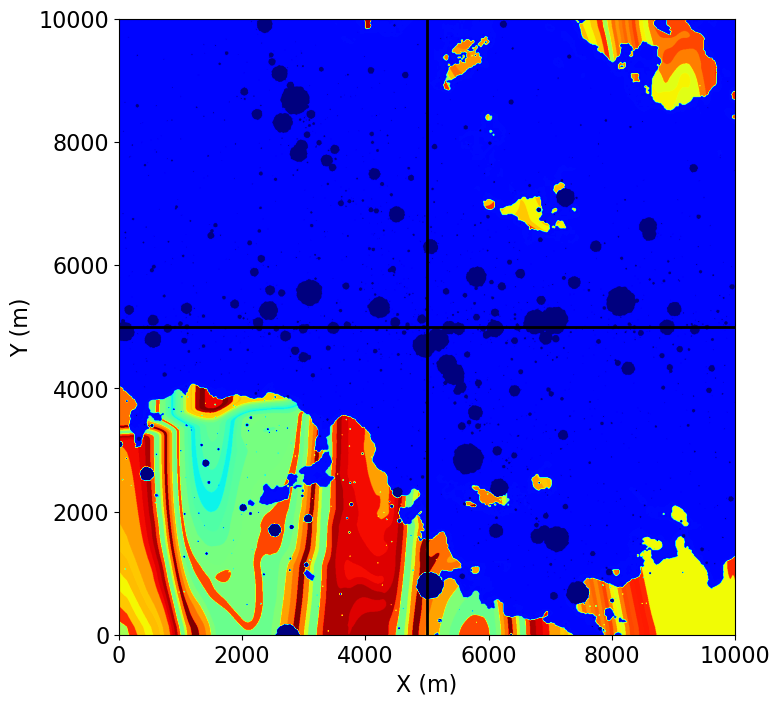

In [12]:
plt.figure(figsize=(8,8))
plt.vlines(5000,ymin=0,ymax=10000,color='black',linewidth=2)
plt.hlines(5000,xmin=0,xmax=10000,color='black',linewidth=2)
plt.imshow(vp[0,:,:].T,cmap='jet',origin='lower',extent=[0,10000,0,10000])
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.show()

### Choose inline
2 Line :
X = 800
and Y = 800 


In [13]:
#Inline X = 800
x = 800
z_lim = 0
vp_x800 = vp[z_lim:,x,:].T / 1000
vs_x800 = vs[z_lim:,x,:].T / 1000
b_x800 = b[z_lim:,x,:].T
rho_x800 = rho[z_lim:,x,:].T

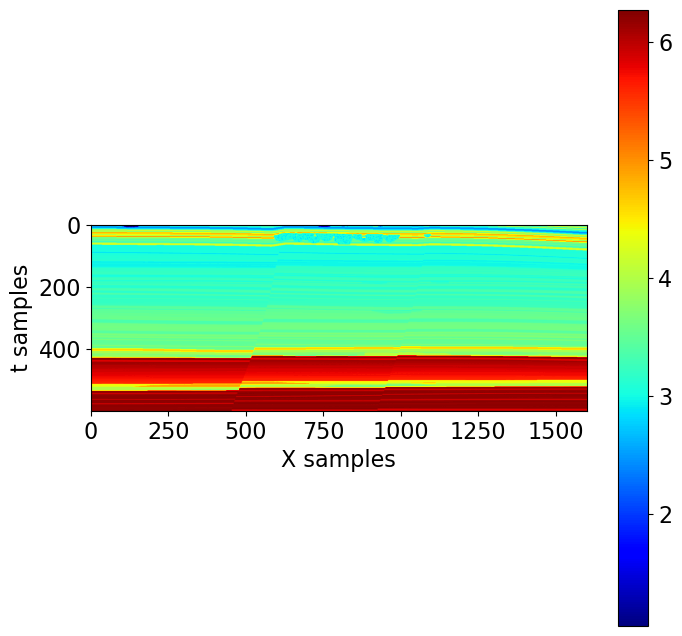

In [14]:
plt.figure(figsize=(8,8))
# plt.vlines(5000,ymin=0,ymax=10000,color='black',linewidth=2)
# plt.hlines(5000,xmin=0,xmax=10000,color='black',linewidth=2)
plt.imshow(vp_x800.T,cmap='jet',origin='upper')
plt.xlabel("X samples")
plt.ylabel("t samples")
plt.colorbar()
plt.show()

### Elastic Modeling X

In [19]:
seismic = Elastic2DDevito()

Operator `initdamp` ran in 0.01 s


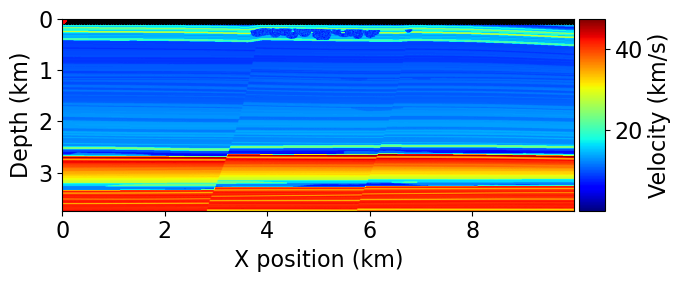

In [22]:
from examples.seismic import Model, plot_velocity

#Model Parameters
origin = (0. , 0.)
shape = vp_x800.shape
dt = 3750/vp_x800.shape[1]
dx = 10000/vp_x800.shape[0]
spacing = (dx,dt)

nbl = 300
t0 = 0
tn = 3750
f0 = 50 #Hz
so = 6

#Acquisition geometry parameters
nrec = 1601
nsrc = 1601
src_x = [0]
src_z = [5]
rec_x = np.linspace(origin[0],10001,nrec)
rec_z = np.ones((nrec))*5
                     
#Create Model
seismic.create_model(vp_x800, vs_x800, rho_x800, shape, origin, spacing, space_order=so, nbl=nbl, fs=True)
seismic.create_geometry(src_x, src_z, rec_x, rec_z, t0=t0, tn=tn, f0=f0,src_type='Ricker')
                       
seismic.plot_velocity(source=True, receiver=True)

In [23]:
rec1,rec2,_,_ = seismic.solve_one_shot(0)

Operator `ForwardElastic` ran in 55.49 s


<Axes: xlabel='X position (km)', ylabel='Time (s)'>

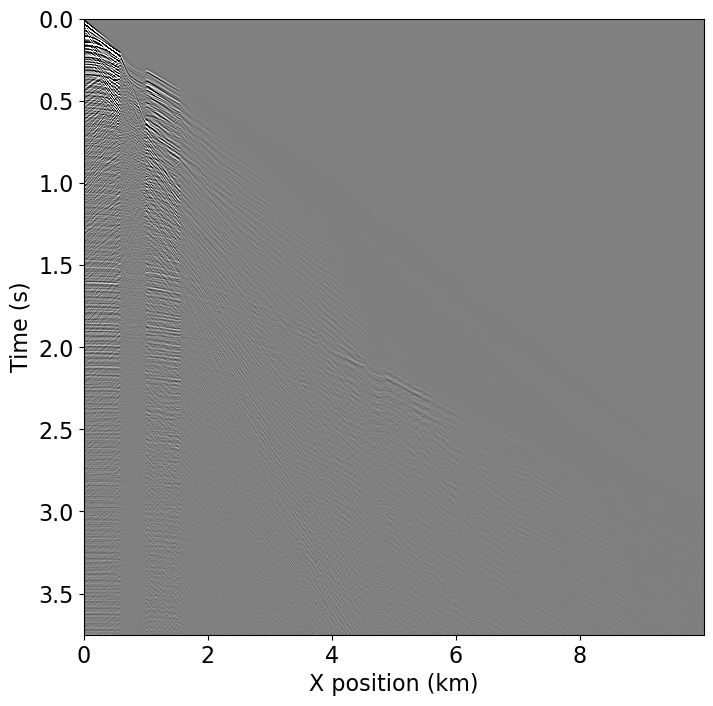

In [24]:
seismic.plot_shotrecord(rec1.data,clip=1e-2,cmap='gray')

In [27]:
np.savez("/home/khatamm/AridMCSlopes/data/X_zero_devito.npz", rec1=rec1.data,rec2=rec2.data)

In [29]:
from pylops.signalprocessing import FFT2D, FFTND

dt = seismic.geometry.time_axis.step
nfft_t, nfft_x = 2**11, 2**9
nt, nx = rec1.data.shape
f = np.fft.fftfreq(nfft_t, dt)
ks = np.fft.fftfreq(nfft_x, dx)
Fop = FFT2D(dims=(nx, nt), nffts=(nfft_x, nfft_t), dtype=complex)

In [30]:
data_fk = Fop*rec1.data.T

(0.2, 0.0)

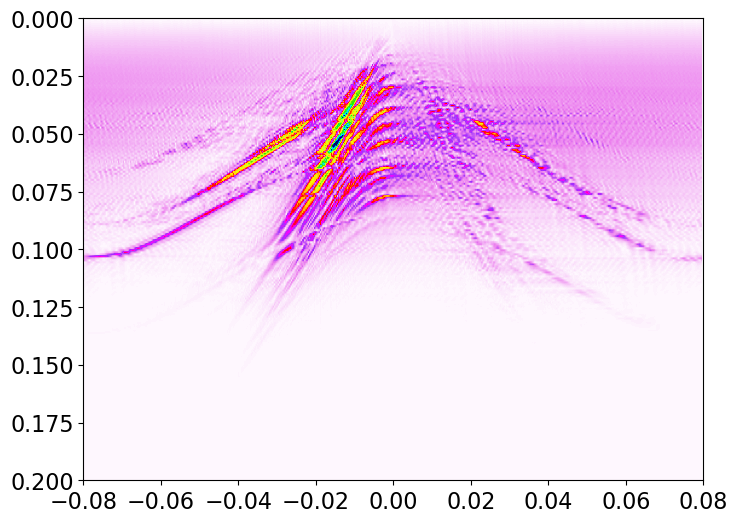

In [31]:
plt.imshow(np.abs(np.fft.fftshift(data_fk)).T[nfft_t//2:], cmap='gist_ncar_r',aspect='auto',vmin=0,vmax=0.1, 
           extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nfft_t//2-1], f[0]))
plt.xlim(-1/(2*dx), 1/(2*dx))
plt.ylim(0.2,0)

## Inline Y

In [ ]:
#Inline X = 800
y = 800
vp_y800 = vp[:,:,y].T / 1000
vs_y800 = vs[:,:,y].T / 1000
b_y800 = b[:,:,y].T
rho_y800 = rho[:,:,y].T

In [ ]:
plt.figure(figsize=(8,8))
plt.vlines(5000,ymin=0,ymax=10000,color='black',linewidth=2)
plt.hlines(5000,xmin=0,xmax=10000,color='black',linewidth=2)
plt.imshow(vp_y800.T,cmap='jet',origin='upper')
plt.xlabel("X samples")
plt.ylabel("t samples")
plt.show()

In [ ]:
seismic_y = Elastic2DDevito()
seismic_y.create_model(vp_y800, vs_y800, rho_y800, shape, origin, spacing, nbl=nbl)
seismic_y.create_geometry(src_x, src_z, rec_x, rec_z, 
                        t0=t0, tn=tn, f0=f0, src_type='Ricker')
                       
seismic_y.plot_velocity(source=True, receiver=True)

In [ ]:
rec1_y, rec2_y, _,_ = seismic_y.solve_one_shot(0,dt=dt)

In [ ]:
seismic_y.plot_shotrecord(rec1_y.data,clip=0.005)